# Lecture 15

## Graph Data

Let us begin our study of graph-structured data by first establishing the formal mathematical foundation of **graph theory**, which provides the language and tools necessary for analyzing and modeling relational data.

A **graph** is a combinatorial structure defined as an ordered pair

$$
G = (V, E),
$$

where $V$ is a finite non-empty set of **vertices** (or **nodes**), and $E \subseteq \{ \{u,v\} \mid u,v \in V,\, u \neq v \}$ is a set of **edges**, each of which is an unordered pair of distinct elements of $V$. In the case where the edges are directed, we instead write $E \subseteq V \times V$, in which case $G$ is called a **directed graph** or **digraph**. For this lecture, unless otherwise stated, we restrict attention to **simple undirected graphs**, meaning graphs with no self-loops and no multiple edges between a pair of vertices.

The **degree** of a vertex $v \in V$, denoted $\deg(v)$, is defined as the number of edges incident to $v$, that is,

$$
\deg(v) = \left| \{ \{v, u\} \in E \mid u \in V \} \right|.
$$

This function measures the local connectivity of the vertex within the graph. In a simple undirected graph, the **Handshaking Lemma** asserts that

$$
\sum_{v \in V} \deg(v) = 2|E|,
$$

a consequence of the fact that each edge contributes exactly twice to the total degree count, once for each endpoint.

A **path** in a graph $G = (V,E)$ is a sequence of vertices $(v_0, v_1, \dots, v_k)$ such that $\{v_{i-1}, v_i\} \in E$ for all $i = 1, \dots, k$. If all vertices in the sequence are distinct, the path is said to be **simple**. The number $k$ is referred to as the **length** of the path. The existence of a path between two vertices $u$ and $v$ implies that they belong to the same **path-connected component**.

The graph $G$ is said to be **connected** if for every pair of vertices $u,v \in V$, there exists a path in $G$ from $u$ to $v$. Otherwise, $G$ is **disconnected**, and the set of equivalence classes under the relation "connected by a path" partitions $V$ into **connected components**.

A particularly important structural element of a graph is a **bridge**, also known as a **cut-edge**. An edge $e \in E$ is called a bridge if its removal increases the number of connected components of the graph. More precisely, if $G' = (V, E \setminus \{e\})$ and the number of connected components in $G'$ is greater than that in $G$, then $e$ is a bridge. The presence of bridges indicates critical connections whose removal leads to the fragmentation of the network.

These elementary definitions lay the groundwork for interpreting complex data through the lens of graph-theoretic structures. Many real-world datasets—ranging from social networks and molecular structures to road systems and bibliographic corpora—naturally admit a representation in terms of vertices and edges. In subsequent sections, we shall build upon these notions by introducing additional graph invariants, matrix representations, and algorithms for analyzing such data.



In [23]:
import networkx as nx
import numpy as np
import pandas as pd
import duckdb as db

from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph

from scipy.sparse import csgraph
from scipy.sparse.linalg import cg

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet', download_dir='/home/kaygun/local/lib/nltk_data')
from nltk.tag import pos_tag, UnigramTagger, AffixTagger, BigramTagger, HiddenMarkovModelTagger
from nltk.stem import WordNetLemmatizer

import re
from itertools import combinations
from collections import Counter

from urllib.request import urlopen

import matplotlib.pyplot as plt
import gravis as gv

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/kaygun/local/lib/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/kaygun/local/lib/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/kaygun/local/lib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Some Examples

Let us now illustrate the basic graph-theoretic concepts—vertices, edges, degrees, paths, components, and bridges—using Python and the `networkx` library. We shall construct a simple undirected graph and compute its key structural properties explicitly.

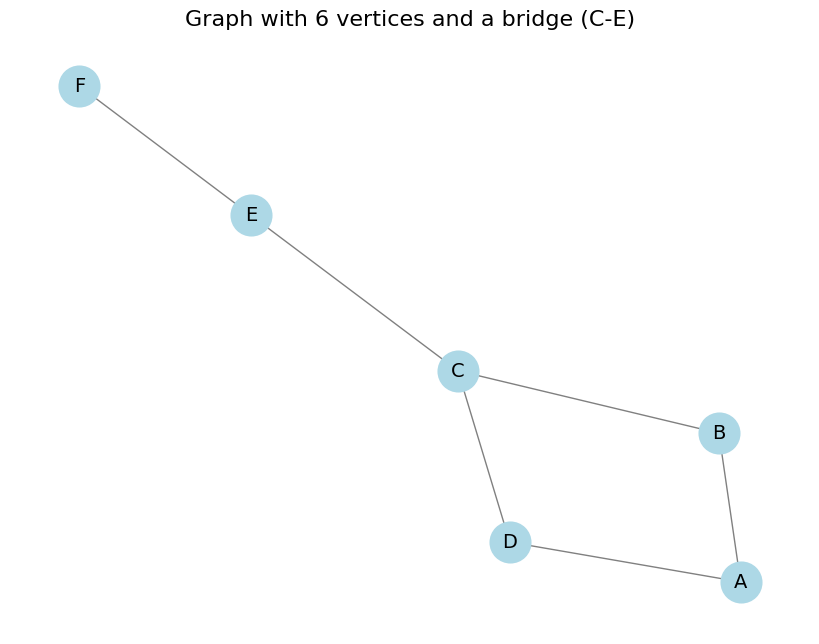

In [2]:
# Define the graph
G = nx.Graph()

# Add vertices
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F'])

# Add edges
G.add_edges_from([
    ('A', 'B'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'A'),
    ('C', 'E'),  # Bridge
    ('E', 'F')
])

# Visualize the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, edge_color='gray', linewidths=2, font_size=14)
plt.title("Graph with 6 vertices and a bridge (C-E)", fontsize=16)
plt.show()

This graph consists of six vertices $V = \{A, B, C, D, E, F\}$, and seven edges. The subgraph induced by $\{A, B, C, D\}$ forms a cycle, while the path $C \to E \to F$ connects to this cycle through a single edge.

We now compute basic invariants:

In [3]:
# Degrees of each vertex
print("Vertex degrees:")
for v in G.nodes():
    print(f"deg({v}) = {G.degree[v]}")

# Check connected components
components = list(nx.connected_components(G))
print("\nConnected components:")
for i, comp in enumerate(components, 1):
    print(f"Component {i}: {comp}")

# Check for bridges
bridges = list(nx.bridges(G))
print("\nBridges in the graph:")
for u, v in bridges:
    print(f"Bridge: ({u}, {v})")

# Check if the graph is connected
is_conn = nx.is_connected(G)
print(f"\nIs the graph connected? {'Yes' if is_conn else 'No'}")

# Find all simple paths from A to F
paths = list(nx.all_simple_paths(G, source='A', target='F'))
print(f"\nSimple paths from A to F:")
for path in paths:
    print(path)

Vertex degrees:
deg(A) = 2
deg(B) = 2
deg(C) = 3
deg(D) = 2
deg(E) = 2
deg(F) = 1

Connected components:
Component 1: {'C', 'F', 'D', 'B', 'E', 'A'}

Bridges in the graph:
Bridge: (C, E)
Bridge: (E, F)

Is the graph connected? Yes

Simple paths from A to F:
['A', 'B', 'C', 'E', 'F']
['A', 'D', 'C', 'E', 'F']


### Explanation

* The **degree** of each vertex corresponds to the number of edges incident to it. For instance, vertex $C$ has degree 3.
* The **connected components** are computed using a traversal algorithm; in this case, the graph is connected, hence consists of a single component.
* The edge $(C, E)$ is identified as a **bridge**. Its removal disconnects $E$ and $F$ from the rest of the graph.
* The list of **simple paths** from vertex $A$ to vertex $F$ reveals the redundant or critical routing information encoded in the graph's structure.

This example illustrates how combinatorial definitions manifest in a concrete computational setting, and how Python can be used to investigate graph-structured data empirically.


## Representations of Graphs

Let us now examine the fundamental *matrix representations* of graphs, which encode the combinatorial structure of a graph in algebraic form. These representations are indispensable for both theoretical investigations and practical algorithms, especially in data science applications where numerical linear algebra methods are employed to analyze graph-structured data.

Let $G = (V, E)$ be a finite simple undirected graph with $|V| = n$, where we fix an ordering $V = \{v_1, v_2, \dots, v_n\}$. The two canonical matrix representations we shall consider are the **adjacency matrix** and the **graph Laplacian**.

### The Adjacency Matrix

The **adjacency matrix** $A \in \mathbb{R}^{n \times n}$ of the graph $G$ is defined by:

$$
A_{ij} = 
\begin{cases}
1 & \text{if } \{v_i, v_j\} \in E, \\
0 & \text{otherwise}.
\end{cases}
$$

Since $G$ is undirected and simple, $A$ is a symmetric $0$-$1$ matrix with zeros on the diagonal.

Let us compute this matrix explicitly using the graph from our previous Python example:

```python
# Adjacency matrix
A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
print("Adjacency matrix A:\n", A)
```

This matrix encodes direct pairwise connectivity in the graph. For instance, if vertex $v_i$ is adjacent to $v_j$, then $A_{ij} = 1$. Note that the eigenvalues of $A$ contain global structural information about the graph, and are central to **spectral graph theory**.

### The Degree Matrix

The **degree matrix** $D \in \mathbb{R}^{n \times n}$ is a diagonal matrix where each diagonal entry is the degree of the corresponding vertex:

$$
D_{ii} = \deg(v_i), \quad D_{ij} = 0 \text{ for } i \neq j.
$$

In Python:

In [4]:
# Adjacency matrix of G we defined earlier
A = nx.adjacency_matrix(G).todense()
print("Adjacency matrix A:\n", A)

# The degree matrix of G we defined earlier
degrees = dict(G.degree())
deg_list = [degrees[v] for v in sorted(G.nodes())]
D = np.diag(deg_list)
print("Degree matrix D:\n", D)

Adjacency matrix A:
 [[0 1 0 1 0 0]
 [1 0 1 0 0 0]
 [0 1 0 1 1 0]
 [1 0 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 0 0 1 0]]
Degree matrix D:
 [[2 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 2 0]
 [0 0 0 0 0 1]]


### The Graph Laplacian

The **(unnormalized) Laplacian matrix** $L \in \mathbb{R}^{n \times n}$ is defined by:

$$
L = D - A.
$$

That is, for each pair $i \neq j$,

$$
L_{ij} =
\begin{cases}
-1 & \text{if } \{v_i, v_j\} \in E, \\
0 & \text{otherwise},
\end{cases}
\quad
\text{and} \quad
L_{ii} = \deg(v_i).
$$

The Laplacian is a real symmetric positive semi-definite matrix. It arises naturally in the context of discrete differential operators, random walks, and diffusion processes. One of its fundamental properties is that the multiplicity of the eigenvalue 0 of $L$ equals the number of connected components in $G$.

In [5]:
L = D - A
print("Laplacian matrix L = D - A:\n", L)

Laplacian matrix L = D - A:
 [[ 2 -1  0 -1  0  0]
 [-1  2 -1  0  0  0]
 [ 0 -1  3 -1 -1  0]
 [-1  0 -1  2  0  0]
 [ 0  0 -1  0  2 -1]
 [ 0  0  0  0 -1  1]]


These matrix constructions provide algebraic access to graph structure and serve as the foundation for algorithms in spectral clustering, semi-supervised learning, node embeddings, and beyond.

## Fundamental Concepts in Working with Graph Data

### Centrality and Centrality Measures

We now turn to the study of **centrality**, a fundamental notion in the analysis of graph-structured data. The centrality of a node is an attempt to quantify its "importance," "influence," or "relevance" within the overall structure of the graph. While the exact definition of centrality depends on the context and application, several mathematically precise and conceptually distinct measures of centrality have been developed. Each corresponds to a different intuition about what it means for a node to be "central."

Let $G = (V, E)$ be a simple undirected graph with $|V| = n$. Let us denote the adjacency matrix of $G$ by $A \in \mathbb{R}^{n \times n}$, the degree of a vertex $v \in V$ by $\deg(v)$, and the shortest-path distance between nodes $u, v \in V$ by $d(u,v)$.


### 1. **Degree Centrality**

The most immediate and local notion of centrality is **degree centrality**, defined by:

$$
C_D(v) = \deg(v).
$$

This measure simply counts the number of direct neighbors of a node. It is maximal for nodes that are directly connected to the largest number of other nodes. In data science applications, it captures local influence or immediate connectivity (e.g., number of followers in a social network).

For normalized comparison, one defines the **normalized degree centrality** as:

$$
\widetilde{C}_D(v) = \frac{\deg(v)}{n - 1},
$$

which maps the range to $[0,1]$.


### 2. **Closeness Centrality**

The **closeness centrality** of a vertex $v$ is a measure of how close $v$ is to all other nodes in the graph. It is defined as the reciprocal of the average shortest-path distance from $v$ to all other reachable vertices:

$$
C_C(v) = \left( \sum_{u \in V \setminus \{v\}} d(v,u) \right)^{-1}.
$$

In disconnected graphs, one must modify the definition to restrict to the connected component of $v$, or to use harmonic means (as in *harmonic centrality*):

$$
C_{H}(v) = \sum_{u \neq v} \frac{1}{d(v,u)},
$$

where $1/d(v,u) = 0$ if $u$ is unreachable from $v$. This avoids division by infinity and remains meaningful in general graphs.


### 3. **Betweenness Centrality**

**Betweenness centrality** captures the idea of a node acting as a "broker" or "gatekeeper" in the flow of information. It is defined as:

$$
C_B(v) = \sum_{\substack{s,t \in V \\ s \neq t \neq v}} \frac{\sigma_{st}(v)}{\sigma_{st}},
$$

where:

* $\sigma_{st}$ is the number of shortest paths from $s$ to $t$,
* $\sigma_{st}(v)$ is the number of those paths that pass through $v$.

Nodes with high betweenness centrality lie on many shortest paths and are thus critical for efficient communication across the graph. This measure is particularly useful in network resilience and influence maximization studies.


### 4. **Eigenvector Centrality**

While degree centrality counts the number of neighbors, **eigenvector centrality** weights neighbors according to their own centrality. Formally, it assigns a centrality score $x_v$ to each vertex $v \in V$, satisfying:

$$
x_v = \frac{1}{\lambda} \sum_{u \in V} A_{vu} x_u,
$$

where $A$ is the adjacency matrix of $G$, and $\lambda$ is a constant. In vector notation, we have:

$$
Ax = \lambda x,
$$

so that $x$ is an eigenvector of $A$. We typically take the **principal eigenvector**, corresponding to the largest eigenvalue $\lambda_1$, by the Perron–Frobenius theorem (when $G$ is connected and $A$ is non-negative).

This measure reflects not just how many neighbors a node has, but also how central those neighbors are. It underlies Google's **PageRank**, which we will treat shortly as a stochastic adaptation.


### 5. **Katz Centrality**

To overcome the fact that eigenvector centrality may assign zero to disconnected or low-degree nodes, **Katz centrality** introduces an attenuation factor $\alpha > 0$ and computes:

$$
C_K(v) = \sum_{k=1}^{\infty} \sum_{u \in V} \alpha^k (A^k)_{uv},
$$

where $A^k_{uv}$ counts the number of walks of length $k$ from $u$ to $v$. This sum converges when $\alpha < \frac{1}{\lambda_1}$, where $\lambda_1$ is the spectral radius of $A$. In matrix form:

$$
C_K = (I - \alpha A)^{-1} \beta \mathbf{1},
$$

where $\beta$ is a scaling factor and $\mathbf{1}$ is the all-ones vector.


### 6. **PageRank**

A variation of Katz centrality applied to directed graphs with stochastic transition matrices leads to **PageRank**. It defines centrality as the stationary distribution $\pi \in \mathbb{R}^n$ of a random walk with teleportation:

$$
\pi = \alpha P^T \pi + (1 - \alpha) \frac{\mathbf{1}}{n},
$$

where $P$ is the column-stochastic adjacency matrix and $\alpha \in (0,1)$ is the teleportation parameter (typically $\alpha \approx 0.85$).

This can be viewed as solving:

$$
\pi = \left(I - \alpha P^T\right)^{-1} \left(\frac{1 - \alpha}{n} \mathbf{1} \right).
$$



## An Explicit Computational Example

Let us consider the following graph:


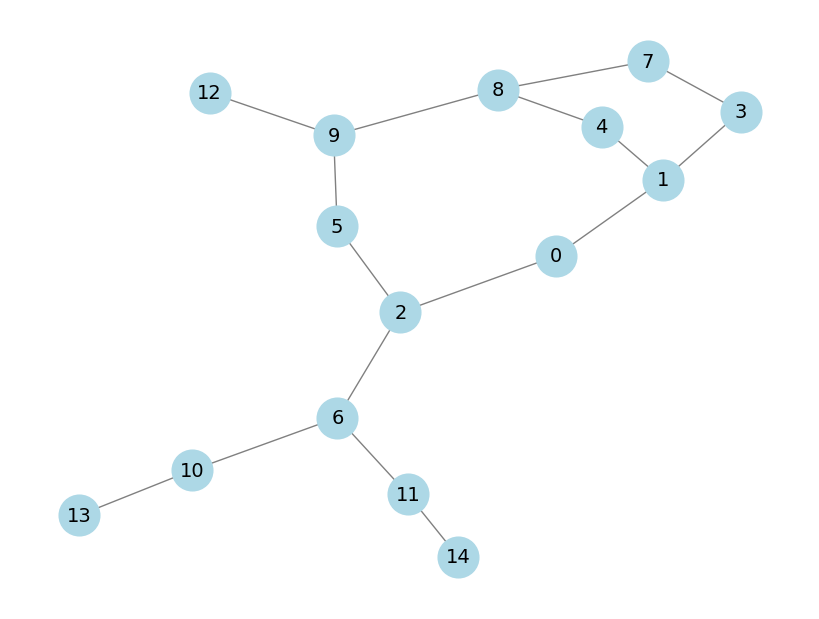

In [6]:
G = nx.Graph()
edges = [
    (0, 1), (0, 2), (1, 3), (1, 4),
    (2, 5), (2, 6), (3, 7), (4, 8),
    (5, 9), (6, 10), (6, 11), (9, 12),
    (10, 13), (11, 14), (7, 8), (8, 9)
]
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, edge_color='gray', linewidths=2, font_size=14)
plt.show()

In [7]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
katz_centrality = nx.katz_centrality(G, alpha=0.1, beta=1.0)
pagerank = nx.pagerank(G, alpha=0.85)

centrality_df = pd.DataFrame({
    'Degree': degree_centrality,
    'Closeness': closeness_centrality,
    'Betweenness': betweenness_centrality,
    'Eigenvector': eigenvector_centrality,
    'Katz': katz_centrality,
    'PageRank': pagerank
})

# Round for readability (optional)
centrality_df = centrality_df.round(4)

centrality_df

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank
0,0.1429,0.3784,0.2473,0.2902,0.2571,0.0590
1,0.2143,0.3500,0.2253,0.3563,0.2781,0.0852
2,0.2143,0.4242,0.5440,0.3397,0.2807,0.0878
3,0.1429,0.2917,0.0549,0.2589,0.2545,0.0594
4,0.1429,0.3111,0.0440,0.3052,0.2571,0.0584
5,0.1429,0.3784,0.2527,0.2796,0.2571,0.0604
6,0.2143,0.3684,0.4835,0.2447,0.2797,0.0955
7,0.1429,0.2692,0.0385,0.2646,0.2547,0.0595
8,0.2143,0.3256,0.1593,0.3755,0.2802,0.0857
9,0.2143,0.3590,0.2802,0.3307,0.2779,0.0902


The table above presents all major centrality measures—Degree, Closeness, Betweenness, Eigenvector, Katz, and PageRank—for each node in the example graph. These values offer a multifaceted view of each node's role in the network.


### Comparative Insight

The following table summarizes the alignment between measures:

| Measure     | Emphasis                           | High for   | Low for    |
| ----------- | ---------------------------------- | ---------- | ---------- |
| Degree      | Local connectivity                 | 1, 2, 6    | 12, 13, 14 |
| Closeness   | Average geodesic distance          | 0, 5       | 12, 13, 14 |
| Betweenness | Control over information flow      | 2, 6, 0, 1, 5, 9  | 12, 13, 14  |
| Eigenvector | Influence via recursive centrality | 1, 2, 8, 9    | 13, 14     |
| Katz        | Reachability via walks             | 1, 2, 6, 8, 9 | 12, 13, 14 |
| PageRank    | Probabilistic centrality           | 1, 2, 6, 8, 9 | 12, 13, 14 |


Each centrality measure highlights a different structural aspect of the graph. Degree and eigenvector centralities privilege highly connected core nodes. Closeness and betweenness centralities emphasize nodes that enable efficient or frequent access between regions. Katz and PageRank provide a more nuanced view that accounts for indirect influence. The agreement among these measures in identifying nodes $1$, $2$, $6$, and $8$ as central validates their importance from multiple topological perspectives.


Let us now analyze the centrality measures computed for the graph with 15 nodes in the previous example. The graph, as constructed, consists of a core region formed by vertices $\{0,1,2,3,4,5,6\}$, which is relatively dense and interconnected, and a number of peripheral branches such as $\{10,13\}$, $\{11,14\}$, and $\{9,12\}$. This structure naturally lends itself to interpreting how the various centrality measures reflect different notions of node "importance" or influence in the network.


### Degree Centrality

Recall that the degree centrality of a node $v$ is defined as:

$$
C_D(v) = \frac{\deg(v)}{n-1},
$$

where $n = 15$ is the number of nodes in the graph. This measure simply counts the number of immediate neighbors.

Nodes with the highest degree centrality include:

* Nodes $1, 2, 6, 8, 9$, all with values approximately $0.2143$, indicating each has $3$ immediate neighbors.
* Nodes like $0, 3, 4, 5, 10, 11$ have a degree of $2$, while the leaves $\{12,13,14\}$ have a degree of $1$.

This suggests that nodes $1$, $2$, and $6$ are structurally central in the sense of local connectivity: they serve as *hubs* linking to several regions of the graph.


### Closeness Centrality

Closeness centrality is defined as the reciprocal of the sum of shortest-path distances from a node to all other reachable nodes:

$$
C_C(v) = \left( \sum_{u \in V \setminus \{v\}} d(v,u) \right)^{-1}.
$$

This measure captures the efficiency with which a node can reach others in the graph.

Nodes $0$ and $5$ attain the highest closeness centrality values (approximately $0.3784$), which is not surprising given their role as *intermediaries* between the dense core and the outer leaves. These nodes are located along the central horizontal path connecting the upper and lower parts of the graph, and hence have small average distances to other nodes.

The lowest closeness values occur at nodes $12$, $13$, and $14$, all leaf nodes at the ends of linear branches. These nodes are the most peripheral in terms of geodesic distance.


### Betweenness Centrality

Betweenness centrality is defined by:

$$
C_B(v) = \sum_{s \ne t \ne v} \frac{\sigma_{st}(v)}{\sigma_{st}},
$$

where $\sigma_{st}$ is the number of shortest paths from $s$ to $t$, and $\sigma_{st}(v)$ is the number that pass through $v$.

Nodes $2$ and $6$ have the highest betweenness centrality values which confirms that they lie on many shortest paths between pairs of nodes. These are classic **bridging nodes**—not in the strict graph-theoretic sense of being cut-edges or articulation points, but as nodes that mediate flow between regions.

Nodes $5$, $9$, $0$, and $1$ also score relatively high in betweenness as they lie along multiple shortest paths from the core to the extremities.

Leaf nodes $\{12,13,14\}$, unsurprisingly, have zero betweenness centrality, as no shortest paths between other nodes traverse them.


### Eigenvector Centrality

Eigenvector centrality assigns centrality scores proportional to the scores of neighboring nodes:

$$
Ax = \lambda x,
$$

where $x$ is the eigenvector corresponding to the dominant eigenvalue of the adjacency matrix $A$.

Nodes $1$, $2$, $8$, and $9$ emerge with the highest eigenvector centralities. These nodes not only have high degree, but are also connected to other nodes with high centrality, especially within the dense core. This reinforces their *core membership* status. However, the status of $6$ is quite curious. Even though it looks very much like $2$, and yet has a relatively low eigen-centrality score.

On the other hand, leaf nodes $13$ and $14$ receive very low eigenvector scores reflecting their peripheral position and lack of connections to influential nodes.

### Katz Centrality

Katz centrality generalizes eigenvector centrality by summing over walks of all lengths with exponential decay:

$$
C_K(v) = \sum_{k=1}^{\infty} \sum_{u \in V} \alpha^k (A^k)_{uv},
$$

for $\alpha < 1/\lambda_{\max}$. This gives even low-degree nodes non-zero centrality if they are connected to central nodes.

Here, Katz centrality amplifies differences in centrality subtly:

* Nodes in the core, like $1$, $2$, $6$, $8$, and $9$ remain dominant.
* Peripheral nodes such as $12$, $13$, and $14$ have slightly higher scores than in eigenvector centrality due to their indirect proximity to the core, i.e., their *potential influence* through walks.


### PageRank

PageRank is a stochastic version of eigenvector centrality adapted to random walks with teleportation:

$$
\pi = \alpha P^T \pi + (1 - \alpha)\frac{\mathbf{1}}{n}.
$$

As expected, PageRank values are qualitatively similar to Katz and eigenvector centralities. Nodes $1$, $2$, $6$, $8$, and $9$ have the highest PageRank values reflecting their role as stable attractors of random walks. These nodes have relatively high connectivity and lie close to the rest of the graph.

Again, the extremal leaves $\{12,13,14\}$ have the lowest PageRank scores as they are sinks in the random walk, contributing little to the stationary distribution.


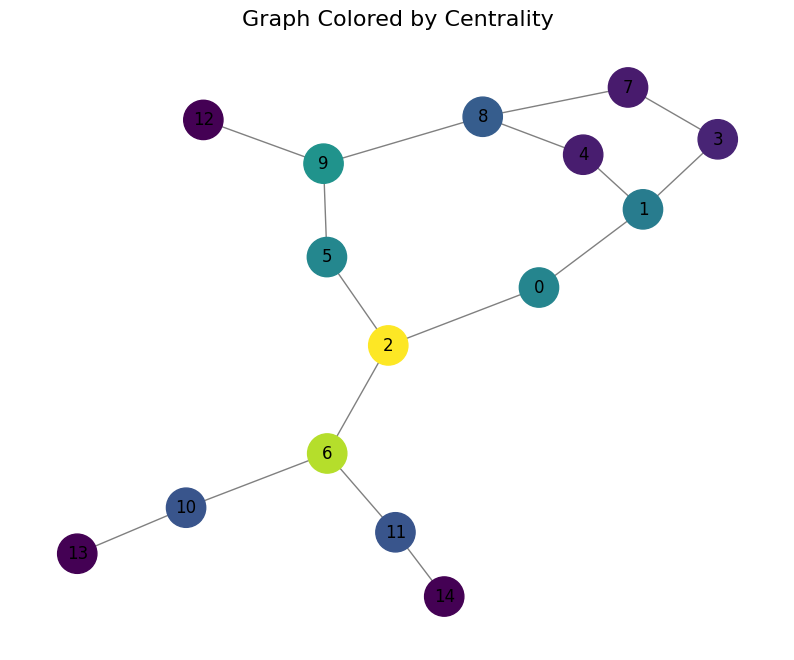

In [8]:
centrality = nx.betweenness_centrality(G)

# Generate layout
pos = nx.spring_layout(G, seed=42)

# Create a list of centrality values for coloring
node_colors = [centrality[node] for node in G.nodes()]

# Plotting
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=800)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                           norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
plt.title("Graph Colored by Centrality", fontsize=16)
plt.axis('off')
plt.show()

## A Literary Example 

[![Alice In Wonderland Character Map \[Infographic\] - HalloweenCostumes.com ...](https://tse1.mm.bing.net/th/id/OIP.uNmZJSNtzHU8WQNhLwKrKAHaSx?pid=Api)](https://www.halloweencostumes.com/blog/p-413-alice-in-wonderland-infographic.aspx)

Below, we will analyzing the character network in *Alice's Adventures in Wonderland*. The application is a compelling intersection of literary analysis and graph theory. By constructing a graph where nodes represent characters and edges denote interactions, we can quantitatively assess character prominence and relational dynamics within the narrative. 

To model the character network nodes are going to be unique characters in the narrative, and we will put an undirected edge between two characters signifies at least one direct interaction or co-occurrence within a scene or chapter. This approach aligns with methodologies in computational literary studies, where character co-occurrence graphs are utilized to analyze narrative structures. 

### Centrality Measures and Their Interpretations

Applying centrality metrics to the graph yields insights into character roles:

* **Degree Centrality**: Quantifies the number of direct connections a character has. Alice, as the protagonist, exhibits the highest degree centrality, reflecting her interactions with a multitude of characters.

* **Betweenness Centrality**: Measures the extent to which a character lies on the shortest paths between others. Characters like the Cheshire Cat and the White Rabbit may have elevated betweenness centrality, acting as bridges between narrative segments.

* **Closeness Centrality**: Assesses how close a character is to all others in the network. Characters central to the narrative progression, such as the Queen of Hearts, may display high closeness centrality.

* **Eigenvector Centrality**: Evaluates a character's influence based on the centrality of their connections. Characters interacting with other prominent figures, like the Mad Hatter, may score high in this measure.

In [9]:
with urlopen('https://www.gutenberg.org/ebooks/11.txt.utf-8') as url:
     raw = url.read()

alice = nltk.sent_tokenize(raw[1500:155430].decode('utf-8'))

In [10]:
pairs = []
for x in alice:
    words = nltk.word_tokenize(re.sub('_',' ',x))
    tagged = pos_tag(words)
    tmp = []
    for w in tagged:
        if w[1] == 'NNP' and len(w[0])>2 and w[0]!='Mrs' and w[0]!='Miss' and w[0]!='Ill':
            tmp.append(w[0])
            if len(tmp)==2:
                pairs.append(tuple(tmp))
            elif len(tmp)>2:
                for aa in combinations(tmp,2):
                    pairs.append(tuple(aa))

graph = Counter(pairs)
edges = [ k for k,v in graph.items() if k[0]!= k[1] and v>10 ]
edges

[('Alice', 'White'),
 ('Alice', 'Rabbit'),
 ('Rabbit', 'Alice'),
 ('White', 'Rabbit'),
 ('Come', 'Alice'),
 ('Well', 'Alice'),
 ('Mouse', 'Alice'),
 ('Alice', 'Mouse'),
 ('Alice', 'William'),
 ('Don', 'Alice'),
 ('Mouse', 'Let'),
 ('Edwin', 'Morcar'),
 ('Mouse', 'Fury'),
 ('Mouse', 'Said'),
 ('Alice', 'Well'),
 ('Alice', 'Caterpillar'),
 ('Father', 'William'),
 ('Alice', 'Father'),
 ('Father', 'Pray'),
 ('William', 'Pray'),
 ('Pigeon', 'Alice'),
 ('Alice', 'Pigeon'),
 ('Duchess', 'Alice'),
 ('Cheshire', 'Cat'),
 ('March', 'Hare'),
 ('Queen', 'Alice'),
 ('Alice', 'March'),
 ('Hatter', 'Dormouse'),
 ('Dormouse', 'Alice'),
 ('Alice', 'Hatter'),
 ('Hatter', 'Alice'),
 ('Dormouse', 'Hatter'),
 ('Hatter', 'March'),
 ('Queen', 'Hearts'),
 ('Yes', 'Alice'),
 ('Alice', 'Dormouse'),
 ('Alice', 'Take'),
 ('Dormouse', 'March'),
 ('Alice', 'Queen'),
 ('Knave', 'King'),
 ('Hearts', 'King'),
 ('Queen', 'Knave'),
 ('King', 'Queen'),
 ('Queen', 'King'),
 ('Mock', 'Turtle'),
 ('Mock', 'Alice'),
 ('Turtl

In [11]:
G = nx.from_edgelist(edges)
degree_centrality = nx.degree_centrality(G)
gv.vis(G,node_hover_neighborhood=True)

## Another Example

### Istanbul Public Transportation Data



In [12]:
data = pd.read_csv('../data/hourly_transportation_202410.csv',sep=',')

In [13]:
lines = db.sql("""
    select line, sum(number_of_passenger) as passengers from data
       group by line
       order by passengers desc
""").to_df()
lines

,line,passengers
0,AVCILAR-ZINCIRLIKUYU,3667754.0
1,HALKALI - GEBZE,3080010.0
2,YENIKAPI - HACIOSMAN,2482138.0
3,KABATAS-BAGCILAR,1738230.0
4,YENIKAPI - HAVALIMANI,1688646.0
...,...,...
831,BEYLIKDUZU - AVCILAR,24.0
832,KARTAL-MECIDIYEKOY-SISLI,7.0
833,YESILPINAR-OTOGAR,4.0
834,BINEVLER-YENIKAPI,3.0


In [14]:
edges = []
for x in lines.itertuples():
    tmp = [y.strip() for y in re.split('-|–|/',x[1])]
    if len(tmp) == 2:
        edges.append(tuple(tmp))
    elif len(tmp)>2:
        for aa in combinations(tmp,2):
            edges.append(tuple(aa))
edges

[('AVCILAR', 'ZINCIRLIKUYU'),
 ('HALKALI', 'GEBZE'),
 ('YENIKAPI', 'HACIOSMAN'),
 ('KABATAS', 'BAGCILAR'),
 ('YENIKAPI', 'HAVALIMANI'),
 ('USKUDAR', 'CEKMEKOY'),
 ('KADIKOY', 'KARTAL'),
 ('KABATAS', 'MAHMUTBEY'),
 ('TOPKAPI', 'HABIBLER'),
 ('KIRAZLI', 'BASAKSEHIR'),
 ('KIRAZLI', 'METROKENT'),
 ('BASAKSEHIR', 'METROKENT'),
 ('CEVIZLIBAG', 'SOGUTLUCESME'),
 ('BOSTANCI', 'DUDULLU'),
 ('BAHARIYE', 'OLIMPIYAT'),
 ('EMINONU', 'ALIBEYKOY'),
 ('TUZLA', 'TOPKAPI'),
 ('KADIKOY', 'FINDIKLI MAHALLESI'),
 ('KADIKOY', 'YEDITEPE UNIVERSITESI'),
 ('FINDIKLI MAHALLESI', 'YEDITEPE UNIVERSITESI'),
 ('GUNESLI', 'BEYAZIT'),
 ('SULTANBEYLI(M.SINAN)', 'ADLIYE'),
 ('SULTANBEYLI(M.SINAN)', 'KARTAL DEV.HST'),
 ('ADLIYE', 'KARTAL DEV.HST'),
 ('GAYRETTEPE', 'ISTANBUL YENI HAVALIMA'),
 ('UMRANIYE DEV.HAST', 'CAKMAK MAH'),
 ('UMRANIYE DEV.HAST', 'ATASEHIR'),
 ('UMRANIYE DEV.HAST', 'USTBOSTANCI'),
 ('CAKMAK MAH', 'ATASEHIR'),
 ('CAKMAK MAH', 'USTBOSTANCI'),
 ('ATASEHIR', 'USTBOSTANCI'),
 ('USKUDAR', 'GUZELTEPE'),
 (

In [15]:
G = nx.from_edgelist(set(edges))
gv.vis(G)

In [16]:
res = nx.centrality.betweenness_centrality(G)
list(sorted(res.items(), key=lambda item: -item[1]))[:10]

[('KADIKOY', 0.19386406665421874),
 ('TAKSIM', 0.148971334760232),
 ('MECIDIYEKOY', 0.147214552145884),
 ('EMINONU', 0.1410555504085996),
 ('USKUDAR', 0.10438609015112957),
 ('KARTAL', 0.09416563480351237),
 ('ALIBEYKOY METRO', 0.08927790119058135),
 ('KABATAS', 0.0667359696918502),
 ('SULTANBEYLI', 0.055188783094592096),
 ('SISLI', 0.0524326463639658)]

## A Final Example

### NBA Player Interaction Network



In [17]:
nba = pd.read_parquet('../data/nba_2019-2020.parquet')
nba

,URL,GameType,Location,Date,Time,WinningTeam,Quarter,SecLeft,AwayTeam,AwayPlay,...,EnterGame,LeaveGame,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,JumpballAwayPlayer,JumpballHomePlayer,JumpballPoss,Unnamed: 40
0,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,720,NOP,Jump ball: D. Favors vs. M. Gasol (L. Ball gai...,...,None,None,None,None,None,None,D. Favors - favorde01,M. Gasol - gasolma01,L. Ball - balllo01,NaN
1,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,708,NOP,L. Ball misses 2-pt jump shot from 11 ft,...,None,None,None,None,None,None,None,None,None,NaN
2,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,707,NOP,Offensive rebound by D. Favors,...,None,None,None,None,None,None,None,None,None,NaN
3,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,707,NOP,D. Favors makes 2-pt layup at rim,...,None,None,None,None,None,None,None,None,None,NaN
4,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,689,NOP,None,...,None,None,None,None,None,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539260,/boxscores/202010110MIA.html,playoff,The Arena Bay Lake Florida,October 11 2020,7:30 PM,LAL,4,29,LAL,None,...,None,None,None,None,None,None,None,None,None,NaN
539261,/boxscores/202010110MIA.html,playoff,The Arena Bay Lake Florida,October 11 2020,7:30 PM,LAL,4,20,LAL,D. Howard makes 3-pt jump shot from 30 ft (ass...,...,None,None,None,None,None,None,None,None,None,NaN
539262,/boxscores/202010110MIA.html,playoff,The Arena Bay Lake Florida,October 11 2020,7:30 PM,LAL,4,15,LAL,None,...,None,None,None,None,None,None,None,None,None,NaN
539263,/boxscores/202010110MIA.html,playoff,The Arena Bay Lake Florida,October 11 2020,7:30 PM,LAL,4,0,LAL,End of 4th quarter,...,None,None,None,None,None,None,None,None,None,NaN


In [18]:
res = db.sql("""
  select count(GameType) as count, Fouler, Fouled 
       from nba
       where GameType = 'regular'
       group by Fouler, Fouled
       order by count desc
""").to_df()
res

,count,Fouler,Fouled
0,455831,None,None
1,15,D. DeRozan - derozde01,None
2,14,D. Green - greendr01,None
3,14,R. Westbrook - westbru01,None
4,13,P. Tucker - tuckepj01,K. Leonard - leonaka01
...,...,...,...
31459,1,J. Ennis - ennisja01,J. Teague - teaguje01
31460,1,J. Collins - collijo01,T. Ross - rosste01
31461,1,K. Martin - martike03,J. Crowder - crowdja01
31462,1,J. Butler - butleji01,J. Layman - laymaja01


In [19]:
edges = [(r[1],r[2]) for i,r in res.iterrows() if r[0]>5 and r[0]<100 and r[2]!=None]
edges

/tmp/ipykernel_107532/4114125294.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edges = [(r[1],r[2]) for i,r in res.iterrows() if r[0]>5 and r[0]<100 and r[2]!=None]


[('P. Tucker - tuckepj01', 'K. Leonard - leonaka01'),
 ('M. Harkless - harklma01', 'J. Harden - hardeja01'),
 ('P. Beverley - beverpa01', 'J. Harden - hardeja01'),
 ('W. Cauley-Stein - caulewi01', 'R. Gobert - goberru01'),
 ('R. Gobert - goberru01', 'N. Jokić - jokicni01'),
 ('D. Brooks - brookdi01', 'D. Booker - bookede01'),
 ("R. O'Neale - onealro01", 'B. Ingram - ingrabr01'),
 ('M. Turner - turnemy01', 'J. Embiid - embiijo01'),
 ('L. Markkanen - markkla01', 'G. Antetokounmpo - antetgi01'),
 ('J. Embiid - embiijo01', 'G. Antetokounmpo - antetgi01'),
 ('C. Joseph - josepco01', 'D. Lillard - lillada01'),
 ('D. Finney-Smith - finnedo01', 'J. Harden - hardeja01'),
 ('D. Dedmon - dedmode01', 'J. Embiid - embiijo01'),
 ('J. Valančiūnas - valanjo01', 'R. Gobert - goberru01'),
 ('D. Brooks - brookdi01', 'D. Fox - foxde01'),
 ('R. Holmes - holmeri01', 'H. Whiteside - whiteha01'),
 ('D. Sabonis - sabondo01', 'A. Drummond - drumman01'),
 ('H. Whiteside - whiteha01', 'L. Dončić - doncilu01'),
 (

In [20]:
graph = nx.from_edgelist(edges)
gv.vis(graph, node_hover_neighborhood=True)

# Advanced Topics

## **Graph-Based Semi-Supervised Learning and Label Propagation**

### **Motivation**:

In many real-world data analysis settings—especially in domains like social networks, biological data, or recommendation systems—we encounter situations where:

* A graph structure is available or can be inferred (e.g., user similarity, interaction networks, co-authorship graphs).
* Labels (e.g., class memberships, annotations) are known only for a small subset of nodes.

This scenario naturally leads to the problem of **semi-supervised learning on graphs**: how can we predict unknown labels on the graph using both the known labels and the structure of the graph?


### **Core Idea**:

Nodes that are **connected** (either directly or via short paths) are more likely to share labels. Hence, the graph Laplacian $L$ or its normalized versions can be used to define a regularization term that encourages **label smoothness** over the graph.

### **Mathematical Framework**:

Assume we have a graph $G = (V, E)$ be a graph with $n$ nodes. Assume also that $y \in \mathbb{R}^n$ is a vector of labels, where some entries are known and others are missing. Our objective is to

> Define a label function $f: V \to \mathbb{R}$ to be estimated on all nodes.

The optimization problem we have is

$$
\min_{f \in \mathbb{R}^n} \left( \sum_{i \in L} (f_i - y_i)^2 + \mu \sum_{i,j} A_{ij} (f_i - f_j)^2 \right),
$$

where $L \subset V$ is the labeled set and $\mu > 0$ is a regularization parameter. The second term can be written using the graph Laplacian:

$$
\sum_{i,j} A_{ij}(f_i - f_j)^2 = f^\top L f,
$$

leading to:

$$
\min_{f} \left( \|P_L(f - y)\|^2 + \mu f^\top L f \right),
$$

where $P_L$ is the projection onto the labeled indices.  This variational formulation links directly to **harmonic functions** on graphs, and its solution has elegant connections to **heat diffusion**, **random walks**, and **spectral filtering**.

### **Applications**:

* Predicting user interests in a social graph.
* Classifying documents in citation networks.
* Identifying protein functions in biological interaction graphs.

### An Explicit Computational Example:

Let us start with generating synthetic data: below we generate a classical **nonlinearly separable dataset** commonly used to test clustering and manifold learning algorithms. The data consists of $n = 200$ two-dimensional points $X \subset \mathbb{R}^2$ partitioned into two crescent-shaped clusters (moons). Each point has a class label $y \in \{0,1\}^n$. We add a Gaussian noise of standard deviation $0.1$ added to the coordinates.


In [21]:
# Generate synthetic data with graph-like structure (two interleaving moons)
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

Next, we construct a **sparse adjacency matrix** representing the **k-nearest neighbor graph** $G = (V, E)$ based on the dataset $X$.

* Each data point $x_i \in X$ becomes a **vertex** $v_i \in V$.
* For each vertex $v_i$, it connects to the $k = 10$ nearest neighbors $v_j$ (in Euclidean distance).
* An edge $(i,j) \in E$ is included **only** if $x_j$ is among the 10 closest points to $x_i$.

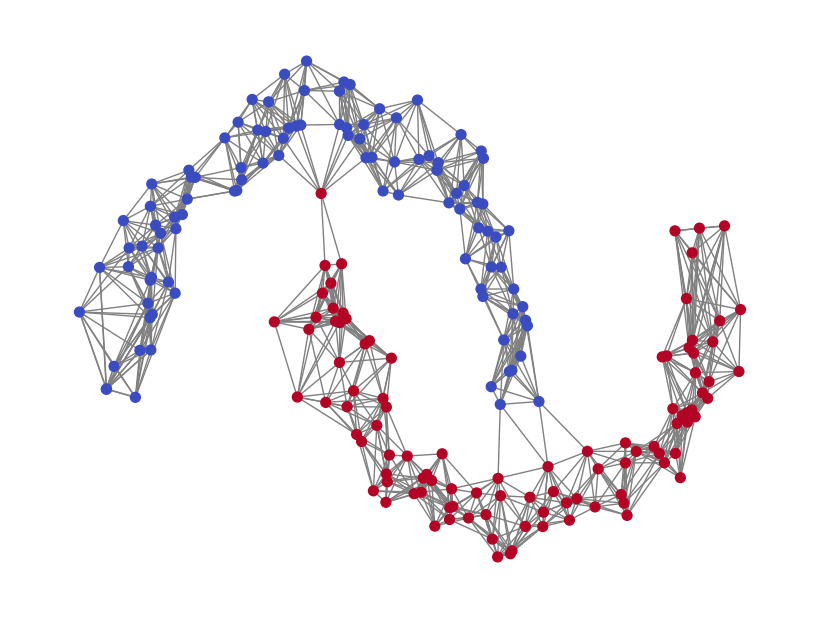

In [24]:
# Construct kNN graph from the data
knn_graph = kneighbors_graph(X, n_neighbors=10, include_self=False)

# Visualize the graph structure
G = nx.from_scipy_sparse_array(knn_graph)
pos = {i: X[i] for i in range(len(X))}
plt.figure(figsize=(8, 6))
nx.draw(G, pos, node_color=y, cmap=plt.cm.coolwarm, node_size=50, edge_color='gray')
plt.show()

The resulting matrix is:

* **Binary**: $A_{ij} = 1$ if $j$ is among the 10 nearest neighbors of $i$,
* **Asymmetric**: unless you symmetrize it later (e.g., via $A \leftarrow A + A^T$),
* **Sparse**: has $O(kn)$ non-zero entries.

This graph $G$ encodes **local geometric structure** of the dataset, approximating the underlying manifold. It is a **discrete analogue of a Riemannian manifold**, over which functions (e.g., labels) can propagate by local averaging, diffusion, or harmonic interpolation.


This following block prepares the **label vector** for a semi-supervised learning task and then applies the **label propagation algorithm** using the `sklearn` implementation. We create a label vector $\ell \in \{-1, 0, 1\}^n$ with initial value $-1$, used as a sentinel for “unknown”. Mathematically, this defines a **partial function** $\ell: V \rightarrow \{0,1\} \cup \{-1\}$, where:

* $\ell(i) = y_i$ for $i \in L \subset V$,
* $\ell(i) = -1$ for $i \in U = V \setminus L$.

Here, $L$ is the set of labeled indices, extracted via `train_test_split` from the original full label set $y$.

In [26]:
# Semi-supervised setup: hide labels for most of the data
labels = -np.ones_like(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)
# Assign known labels to training indices
known_indices = []
for xi, yi in zip(X_train, y_train):
    index = np.where((X == xi).all(axis=1))[0][0]
    labels[index] = yi
    known_indices.append(index)

Next, we get the **complement set** $U$, which is the domain of the unknown label function $f: U \to \mathbb{R}$ to be estimated.

In [27]:
unknown_indices = list(set(range(len(X))) - set(known_indices))

Next, we initialize and fit the **Label Propagation model**, which in the `sklearn` implementation constructs a similarity graph $G$ using the $k$-nearest neighbor rule with $k=10$ using a **graph-based semi-supervised algorithm** to infer the labels $\hat{y}_i$ for all $i \in V$.
The model solves the iterative update:

$$
F^{(t+1)} = \alpha S F^{(t)} + (1 - \alpha) Y,
$$

where:

* $F \in \mathbb{R}^{n \times c}$ is the soft label matrix at iteration $t$,
* $S$ is a normalized similarity matrix (graph kernel),
* $Y$ is the one-hot encoded label matrix (with zeros for unlabeled),
* $\alpha \in (0,1)$ is a relaxation parameter.

The lines `label_prop_model.fit` and then `label_prop_model.transduction_` run the algorithm:

* Builds the internal graph structure using the features $X$,
* Propagates labels via local averaging,
* Stops when convergence is reached (based on label stability or iteration bound).

The model converges to a **harmonic extension** when $\alpha \to 1$, i.e., labels diffuse through the graph with boundary conditions fixed on the labeled nodes.

In [28]:
# Apply Label Propagation
label_prop_model = LabelPropagation(kernel='knn', n_neighbors=10)
label_prop_model.fit(X, labels)
predicted_labels = label_prop_model.transduction_

The field `.transduction_` returns the **hard label assignment** $\hat{y}_i = \arg\max_c F_{ic}$ for all $i \in V$. That is, each node gets assigned to the class whose label has the highest propagated influence.

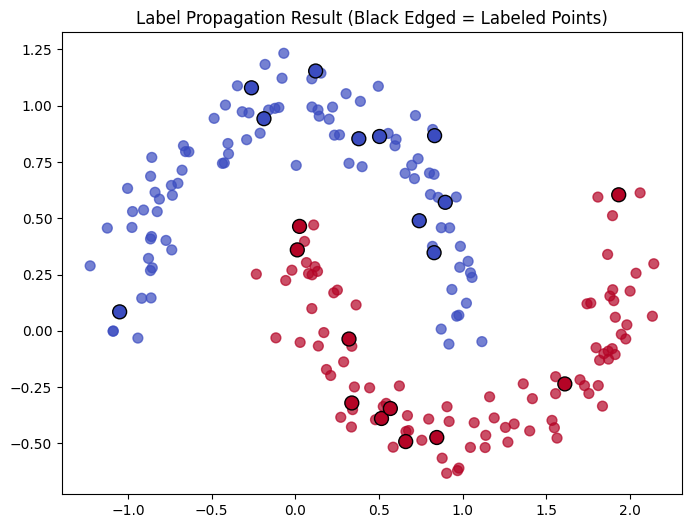

In [29]:
# Visualization of predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap=plt.cm.coolwarm, s=50, alpha=0.7)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='black', s=100, marker='o')
plt.title("Label Propagation Result (Black Edged = Labeled Points)")
plt.show()

In [30]:
# Evaluate only on the test set
true_test_indices = [i for i in range(len(X)) if any((X[i] == x).all() for x in X_test)]
test_accuracy = accuracy_score(y[true_test_indices], predicted_labels[true_test_indices])
print(f"Test Accuracy of Label Propagation: {test_accuracy:.4f}")

Test Accuracy of Label Propagation: 0.9944


## Variational Formulation of Label Propagation

Let $G = (V,E)$ be an undirected graph with $n$ vertices, adjacency matrix $A \in \mathbb{R}^{n \times n}$, and combinatorial Laplacian $L = D - A$. Suppose we are given a label function $f : V \to \mathbb{R}$, where labels are known on a subset $L \subset V$ and unknown on $U = V \setminus L$. Let $y \in \mathbb{R}^n$ be the label vector such that:

$$
y_i = 
\begin{cases}
\text{known}, & \text{if } i \in L, \\\\
\text{undefined}, & \text{if } i \in U.
\end{cases}
$$

We define the energy functional:

$$
\mathcal{E}(f) = \|P_L(f - y)\|^2 + \mu f^\top L f,
$$

where:

* $P_L \in \mathbb{R}^{n \times n}$ is a diagonal projection matrix with entries $(P_L)_{ii} = 1$ if $i \in L$, and 0 otherwise;
* The first term enforces fidelity to known labels;
* The second term promotes smoothness over the graph:

  $$
  f^\top L f = \sum_{i,j} A_{ij} (f_i - f_j)^2,
  $$

  penalizing label variation over adjacent nodes.

Minimizing $\mathcal{E}(f)$ balances **fitting the known labels** with **smooth extension to unlabeled nodes**.


## Connection to Harmonic Functions on Graphs

Suppose we remove the fidelity term and instead enforce exact equality at labeled nodes: $f_i = y_i$ for $i \in L$. The minimization reduces to:

$$
\min_{f \in \mathbb{R}^n} \sum_{i,j} A_{ij}(f_i - f_j)^2 \quad \text{subject to } f|_L = y.
$$

This is a **Dirichlet energy minimization problem**, and the minimizer $f$ satisfies the **discrete Laplace equation** on unlabeled nodes:

$$
(Lf)_i = 0 \quad \text{for all } i \in U,
$$

which expands as:

$$
f_i = \frac{1}{\deg(i)} \sum_{j : (i,j) \in E} f_j.
$$

Thus, $f$ is **harmonic** on $U$, i.e., the value at an unlabeled node is the average of its neighbors' values. This is the core principle behind classical **label propagation**: interpolate labels via harmonic extension.


## Connection to Heat Diffusion

The **heat equation** on a graph is:

$$
\frac{d}{dt} f(t) = -Lf(t), \quad f(0) = f_0.
$$

Its solution is given by:

$$
f(t) = e^{-tL} f_0.
$$

Here, $e^{-tL}$ acts as a **heat kernel**, spreading information over time from initial conditions $f_0$. In the context of label propagation, this captures how known labels "diffuse" across the graph, with nearby nodes being affected earlier.

This leads to **heat kernel smoothing**:

$$
f = e^{-tL} y,
$$

which can be interpreted as a spectral filter (see next section) that dampens high-frequency (i.e., rapidly varying) label assignments.


## Connection to Random Walks

Let $D$ be the degree matrix and define the **random walk transition matrix**:

$$
P = D^{-1}A.
$$

Then $P_{ij}$ is the probability of moving from node $i$ to node $j$ in one step of a random walk.

If labels diffuse by random walks, then the expected label value at a node is the expected value of the labels seen in a walk, modeled by:

$$
f^{(t+1)} = P f^{(t)}.
$$

Repeated application leads to:

$$
f^{(t)} = P^t f^{(0)}.
$$

This is equivalent to a **power iteration** over the graph, stabilizing at a steady-state label distribution under certain conditions. This probabilistic view gives rise to the **random walk label propagation** algorithm.


## Connection to Spectral Filtering

Consider the spectral decomposition of the Laplacian:

$$
L = U \Lambda U^\top,
$$

where $U$ is the matrix of eigenvectors (graph Fourier basis), and $\Lambda$ is the diagonal matrix of eigenvalues.

The label function $f$ can be expanded as:

$$
f = \sum_{k=0}^{n-1} \hat{f}_k u_k,
$$

where $\hat{f}_k = u_k^\top f$ are graph Fourier coefficients.

The Dirichlet energy becomes:

$$
f^\top L f = \sum_{k=1}^{n-1} \lambda_k \hat{f}_k^2,
$$

so that minimizing energy favors small high-frequency components $\hat{f}_k$ for large $\lambda_k$. This is equivalent to applying a **low-pass filter** in the graph Fourier domain.

In other words, **label propagation** solves a regularization problem in the spectral domain that suppresses oscillatory label assignments and promotes smooth, semantically meaningful interpolations.


## Summary

| Viewpoint          | Key Operator       | Interpretation                            |
| ------------------ | ------------------ | ----------------------------------------- |
| Variational        | $L$                | Penalizes label disagreement across edges |
| Harmonic extension | $Lf = 0$ on $U$    | Labels interpolate by neighbor averaging  |
| Heat diffusion     | $f(t) = e^{-tL} y$ | Smooths initial labels over time          |
| Random walk        | $f^{(t)} = P^t y$  | Probabilistic label spreading             |
| Spectral filtering | $f^\top L f$       | Penalizes high-frequency label variations |


These interpretations are not merely equivalent—they are *different faces of the same principle*: label smoothness over graphs. They provide multiple lenses through which students can connect analysis, probability, and computation in data science.

## A Computational Example

Let us start by getting the Laplacian of the graph above. Recall that the **combinatorial Laplacian** of the graph is 

$$
L = D - A
$$

where: $A$ is the adjacency matrix of the graph (from the kNN construction), $D$ is the diagonal degree matrix: $D_{ii} = \sum_j A_{ij}$.


In [31]:
# Convert to CSR format before subscriptable slicing
laplacian = csgraph.laplacian(knn_graph, normed=False).tocsr()

The `.tocsr()` call converts the sparse matrix to **Compressed Sparse Row** format to allow subscript-based slicing like $L[\text{rows}, \text{cols}]$, which is necessary for the block decomposition in the next steps.

Next, we **partition the Laplacian matrix** and the label vector based on known and unknown indices:

$$
L = 
\begin{bmatrix}
L_{LL} & L_{LU} \\\\
L_{UL} & L_{UU}
\end{bmatrix}, \quad
f = 
\begin{bmatrix}
f_L \\\\
f_U
\end{bmatrix}
$$

We are solving the harmonic equation $Lf = 0$ on the **unknown** entries. This gives the system:

$$
L_{UL} f_L + L_{UU} f_U = 0
\Rightarrow
L_{UU} f_U = -L_{UL} f_L
$$

In [32]:
# Split label vector into known and unknown
f_known = labels[known_indices]
L_uu = laplacian[unknown_indices, :][:, unknown_indices]
L_ul = laplacian[unknown_indices, :][:, known_indices]


In the code:

* `L_uu` corresponds to $L_{UU}$,
* `L_ul` corresponds to $L_{UL}$,
* `f_known` is $f_L$.

Next, let us solve numerically  the **linear system**:

$$
L_{UU} f_U = -L_{UL} f_L
$$

using the **conjugate gradient method**, which is efficient for large symmetric positive semidefinite sparse systems like graph Laplacians.

In [33]:
# Solve for unknown labels assuming f satisfies Lf = 0 on unknowns
f_unknown, info = cg(L_uu, -L_ul @ f_known, rtol=1e-6)

The result is a real-valued vector $f_U \in \mathbb{R}^{|U|}$ representing the **harmonic extension** of the labels.

Since $f_U$ consists of **real-valued soft label estimates**, we apply a threshold (here, 0.5) to convert them to binary class labels:

$$
\hat{y}_i = 
\begin{cases}
1 & \text{if } f_i > 0.5 \\\\
0 & \text{otherwise}
\end{cases}
\quad \text{for } i \in U
$$


In [34]:
# Reconstruct full label vector
harmonic_labels = np.copy(labels)
harmonic_labels[unknown_indices] = f_unknown > 0.5

The code above produces a **hard label prediction** vector over all nodes, consistent with known labels and harmonically extended elsewhere. This solves the **Dirichlet problem on a graph**: find a function $f$ minimizing the Dirichlet energy

$$
\sum_{(i,j) \in E} (f_i - f_j)^2,
$$

subject to known boundary conditions $f_L = y_L$. The resulting solution satisfies

$$
Lf = 0 \text{ on } U,
$$

i.e., **discrete harmonicity** on the unlabeled set.

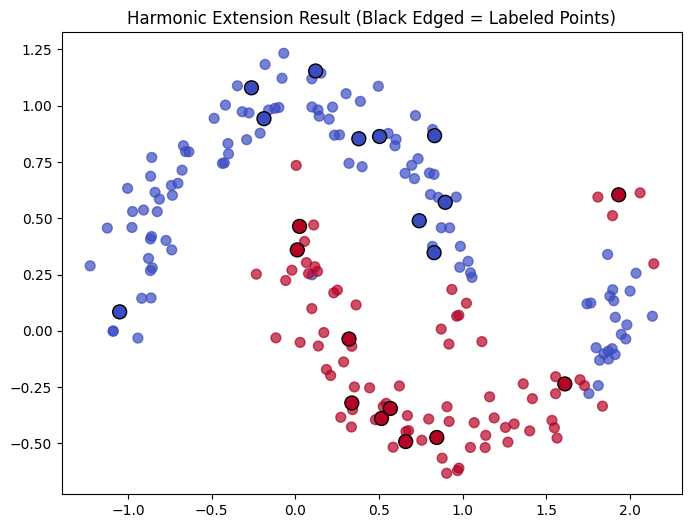

In [35]:
# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=harmonic_labels, cmap=plt.cm.coolwarm, s=50, alpha=0.7)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='black', s=100, marker='o')
plt.title("Harmonic Extension Result (Black Edged = Labeled Points)")
plt.show()

In [36]:
# Accuracy
harmonic_acc = accuracy_score(y[true_test_indices], harmonic_labels[true_test_indices])
print(f"Test Accuracy of Harmonic Extension: {harmonic_acc:.4f}")

Test Accuracy of Harmonic Extension: 0.8333
